In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import util
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

import poutyne as pt
from poutyne import Model
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Important: utiliser les données prétraitées
csv_path = 'data/dataframe.csv'

In [2]:
df = pd.read_csv(csv_path)
df.head()
classes = [
    'Another party (please specify)',
    'Bloc Qu<e9>b<e9>cois',
    'Conservative Party',
    "Don't know/ Prefer not to answer",
    'Green Party',
    'Liberal Party',
    'ndp',
    "People's Party"
]
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30,shuffle = True)

#### Arbres de décision 

In [4]:
clf_first = DecisionTreeClassifier(max_depth=5, random_state=0)

clf_first.fit(X_train, y_train)

y_pred = clf_first.predict(X_test)

In [5]:
print('Test score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = clf_first.predict(X_train)

print('Train score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Test score with criterion gini index: 0.4006
Train score with criterion gini index: 0.4002


In [6]:
depth_clfs = [DecisionTreeClassifier(max_depth=k, random_state=0) for k in range(1,50)]
accuracy_train = []
accuracy_test = []
for clf in depth_clfs:
    clf.fit(X_train, y_train)
    accuracy_train.append(clf.score(X_train, y_train))
    accuracy_test.append(clf.score(X_test, y_test))

<Figure size 1152x864 with 0 Axes>

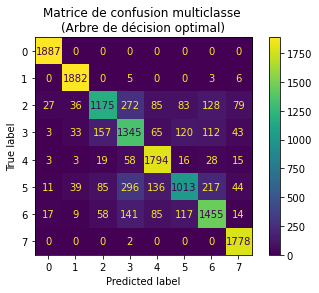

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [7]:
meilleur_clf = depth_clfs[32]
plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(meilleur_clf,X_test,y_test)
plt.title("Matrice de confusion multiclasse \n(Arbre de décision optimal)")

plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

#### Forêts aléatoires :

In [8]:
clf_forest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf_forest.fit(X_train, y_train)

y_forest_pred_test = clf_forest.predict(X_test)
score_test_forest = accuracy_score(y_test, y_forest_pred_test)
f1_test_forest = f1_score(y_test, y_forest_pred_test,average="macro")

y_forest_pred_train = clf_forest.predict(X_train)
score_train_forest = accuracy_score(y_train, y_forest_pred_train)
f1_test_forest = f1_score(y_train, y_forest_pred_train,average="macro")


print(f"clf_forest test accuracy score : {score_test_forest:.2%} \n\
    clf_forest test f1 score : {f1_test_forest:.2%}")
print(f"clf_forest train accuracy score : {score_train_forest:.2%}\n\
    clf_forest train f1 score : {f1_test_forest:.2%}")

clf_forest test accuracy score : 43.44% 
    clf_forest test f1 score : 39.20%
clf_forest train accuracy score : 43.44%
    clf_forest train f1 score : 39.20%


<Figure size 1152x864 with 0 Axes>

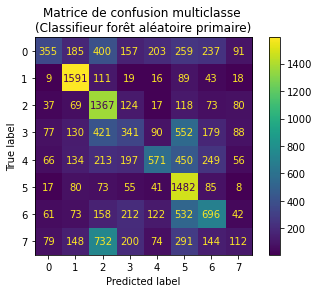

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [9]:
plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(clf_forest,X_test,y_test)
plt.title("Matrice de confusion multiclasse \n(Classifieur forêt aléatoire primaire)")
plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

In [10]:
parameters = {
    "n_estimators":[50,100,250],
    "max_depth":[12,24,32,None]
    
}

cv = GridSearchCV(clf_forest,parameters,cv=6)
cv.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=RandomForestClassifier(max_depth=2, random_state=0),
             param_grid={'max_depth': [12, 24, 32, None],
                         'n_estimators': [50, 100, 250]})

In [11]:
print(f'Best parameters are: {cv.best_params_}')
print("\n")
mean_score = cv.cv_results_['mean_test_score']
std_score = cv.cv_results_['std_test_score']
params = cv.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

Best parameters are: {'max_depth': 32, 'n_estimators': 250}


0.62 + or -0.008 for the {'max_depth': 12, 'n_estimators': 50}
0.623 + or -0.006 for the {'max_depth': 12, 'n_estimators': 100}
0.626 + or -0.006 for the {'max_depth': 12, 'n_estimators': 250}
0.84 + or -0.004 for the {'max_depth': 24, 'n_estimators': 50}
0.843 + or -0.004 for the {'max_depth': 24, 'n_estimators': 100}
0.844 + or -0.003 for the {'max_depth': 24, 'n_estimators': 250}
0.859 + or -0.002 for the {'max_depth': 32, 'n_estimators': 50}
0.86 + or -0.003 for the {'max_depth': 32, 'n_estimators': 100}
0.861 + or -0.003 for the {'max_depth': 32, 'n_estimators': 250}
0.858 + or -0.003 for the {'max_depth': None, 'n_estimators': 50}
0.859 + or -0.003 for the {'max_depth': None, 'n_estimators': 100}
0.861 + or -0.003 for the {'max_depth': None, 'n_estimators': 250}


In [12]:
best_clf_forest = RandomForestClassifier(n_estimators=250, max_depth=32, random_state=10)
best_clf_forest.fit(X_train, y_train)

y_pred_test = best_clf_forest.predict(X_test)
score_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test,average="macro")

y_pred_train = best_clf_forest.predict(X_train)
score_train = accuracy_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train,average="macro")


print(f"best clf_forest test accuracy score : {score_test:.2%} \n\
    best clf_forest test f1 score : {f1_test:.2%}")
print(f"best clf_forest train accuracy score : {score_train:.2%}\n\
    best clf_forest train f1 score : {f1_train:.2%}")


best clf_forest test accuracy score : 87.72% 
    best clf_forest test f1 score : 87.56%
best clf_forest train accuracy score : 99.11%
    best clf_forest train f1 score : 99.11%


<Figure size 1152x864 with 0 Axes>

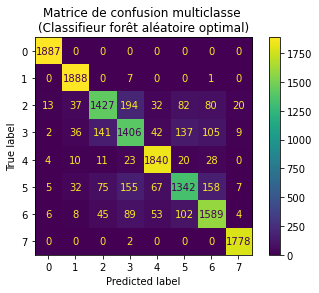

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [13]:
plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(best_clf_forest, X_test, y_test)
plt.title("Matrice de confusion multiclasse \n(Classifieur forêt aléatoire optimal)")
plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

#### Fully-Connected

In [14]:
test_ratio = 0.2
valid_ratio = 0.2

hidden_size = 512
output_size = 8
dropout = 0.0

n_epochs = 30
batch_size = 32
learning_rate = 0.1
min_lr=0.00001
momentum = 0.9

gamma = 0.1
patience = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
input_size = len(df.columns) - 2 # Retirer le ID et l'étiquette

train_dataset = TensorDataset(torch.tensor(X_train.to_numpy()).float(), torch.tensor(y_train.to_numpy()).long())
test_dataset = TensorDataset(torch.tensor(X_test.to_numpy()).float(), torch.tensor(y_test.to_numpy()).long())

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
class FCNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCNetwork, self).__init__()
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        hidden_size_2 = hidden_size
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)

        hidden_size_3 = hidden_size // 2
        self.dropout3 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)

        hidden_size_4 = hidden_size // 4
        self.dropout4 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.bn4 = nn.BatchNorm1d(hidden_size_4)

        hidden_size_5 = hidden_size // 8
        self.dropout5 = nn.Dropout(dropout)
        self.fc5 = nn.Linear(hidden_size_4, hidden_size_5)
        self.bn5 = nn.BatchNorm1d(hidden_size_5)

        self.fc6 = nn.Linear(hidden_size_5, output_size)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout5(x)
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        y = F.log_softmax(x, dim=1)
        return y

In [36]:
network = FCNetwork(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
scheduler = pt.ReduceLROnPlateau(monitor="val_acc", mode='max', patience=patience, factor=gamma, min_lr=min_lr, verbose=True)
model = Model(network, optimizer, criterion, device=device, batch_metrics=["accuracy"])

In [37]:
history = model.fit_generator(train_loader, test_loader, epochs=n_epochs, callbacks=[scheduler])
torch.cuda.empty_cache()

Epoch:  1/30 Train steps: 1875 Val steps: 469 10.33s loss: 1.511461 acc: 45.456970 val_loss: 1.304827 val_acc: 51.736782
Epoch:  2/30 Train steps: 1875 Val steps: 469 9.07s loss: 1.284220 acc: 53.304552 val_loss: 1.236861 val_acc: 55.823722
Epoch:  3/30 Train steps: 1875 Val steps: 469 9.19s loss: 1.157954 acc: 57.695064 val_loss: 1.159185 val_acc: 58.443896
Epoch:  4/30 Train steps: 1875 Val steps: 469 8.60s loss: 1.072671 acc: 60.765423 val_loss: 1.075694 val_acc: 61.297420
Epoch:  5/30 Train steps: 1875 Val steps: 469 8.54s loss: 1.004929 acc: 63.030687 val_loss: 1.004285 val_acc: 63.637576
Epoch:  6/30 Train steps: 1875 Val steps: 469 8.65s loss: 0.944140 acc: 65.130932 val_loss: 0.991961 val_acc: 63.857591
Epoch:  7/30 Train steps: 1875 Val steps: 469 9.12s loss: 0.896115 acc: 66.761122 val_loss: 0.991411 val_acc: 64.950997
Epoch:  8/30 Train steps: 1875 Val steps: 469 8.61s loss: 0.849905 acc: 68.476322 val_loss: 0.984074 val_acc: 65.737716
Epoch:  9/30 Train steps: 1875 Val step

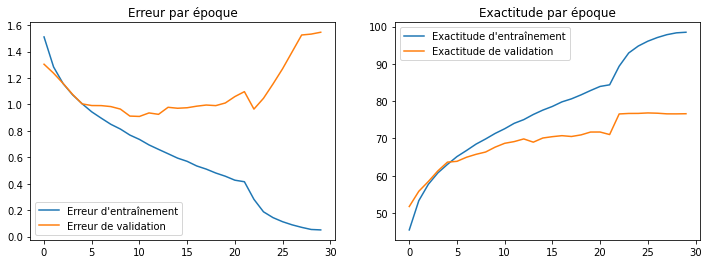

In [38]:
loss_per_epoch = []
acc_per_epoch = []
val_loss_per_epoch = []
val_acc_per_epoch = []
for epoch in history:
    loss_per_epoch.append(epoch['loss'])
    acc_per_epoch.append(epoch['acc'])
    val_loss_per_epoch.append(epoch['val_loss'])
    val_acc_per_epoch.append(epoch['val_acc'])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_per_epoch, label='Erreur d\'entraînement')
plt.plot(val_loss_per_epoch, label='Erreur de validation')
plt.title('Erreur par époque')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_per_epoch, label='Exactitude d\'entraînement')
plt.plot(val_acc_per_epoch, label='Exactitude de validation')
plt.title('Exactitude par époque')
plt.legend()
plt.show()

In [39]:
predictions = model.predict_generator(test_loader, has_ground_truth=True)

# Obtenir la classe ayant le plus grand score
predicted_classes = predictions.argmax(axis=1)

# Obtenir les labels test
ground_truth = torch.tensor(y_test.to_numpy()).long().numpy()

Prediction steps: 469 0.91s                                            


In [40]:
classes = [
    'Another party (please specify)',
    'Bloc Qu<e9>b<e9>cois',
    'Conservative Party',
    "Don't know/ Prefer not to answer",
    'Green Party',
    'Liberal Party',
    'ndp',
    "People's Party"
]
classes_idx = [0, 1, 2, 3, 4, 5, 6, 7]

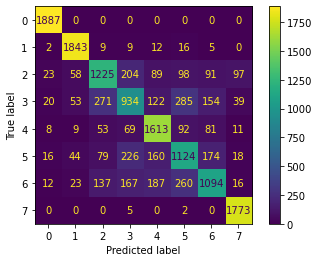

In [41]:
cm = confusion_matrix(ground_truth, predicted_classes, labels=classes_idx)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [42]:
accuracy = accuracy_score(ground_truth, predicted_classes)
precision = precision_score(ground_truth, predicted_classes, average=None)
recall = recall_score(ground_truth, predicted_classes, average=None)
f1 = f1_score(ground_truth, predicted_classes, average=None)

print(f"Accuracy: {accuracy:.2%}")

df_metrics = pd.DataFrame({"Précision": precision, "Rappel": recall, "F1-Score": f1}, index=classes)

df_metrics = df_metrics.applymap(lambda x: f"{x:.2%}")
df_metrics

Accuracy: 76.63%


,Precision,Recall,F1-Score
Another party (please specify),95.88%,100.00%,97.90%
Bloc Qu<e9>b<e9>cois,90.79%,97.20%,93.89%
Conservative Party,69.05%,64.99%,66.96%
Don't know/ Prefer not to answer,57.87%,49.73%,53.49%
Green Party,73.89%,83.32%,78.32%
Liberal Party,59.88%,61.05%,60.46%
ndp,68.42%,57.70%,62.60%
People's Party,90.74%,99.61%,94.97%
